In [1]:
#Technical Analysis Systems (Apostolos Dasilas)
#Taouktsis Xenofon (dai19312)
#Υπολογισμοί ROC (Rate of Change Oscillator)
#Δεδομένα από το [investing.com]
#Τα δεδομένα (.csv) όπως τα κατεβάζουμε απευθείας από το investing.com
#Το αρχείο θα έχει όνομα συμβόλου και μετατροπή από π.χ. ETH.csv σε ETH_md.csv
#UPDATE 080121 - v6

**Εισαγωγή Functions**

In [2]:
#Βήμα 1 | Libraries Input
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Global
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Βήμα 2 | Upload Dataset Function
def upload_dataset():
    data_upload = files.upload()
    filename = list(data_upload.keys())[0]
    filename = re.sub(".csv", "", filename)
    return filename

In [4]:
#Βήμα 3 | ROC calculation Formula
def roc_calculation(dataset,p):
    drop_columns = ['Open', 'High', 'Low', 'Volume']
    dset = dataset.drop(columns = drop_columns)

    roc_values = []
    for i in range(p):
        roc_values.append(np.nan)
    range_a = len(dset)

    t = p #start point
    for i in range(t,range_a):
        tmp_roc = ((dset.iloc[i,1] / dset.iloc[i-p,1])-1)*100
        roc_values.append(tmp_roc)
    roc_values = pd.DataFrame(roc_values)
    roc_values.columns = ['ROC'+'_P'+ str(p)]

    result_values = pd.DataFrame()
    result_values = pd.concat([dset, roc_values], axis=1)
    return result_values

In [5]:
#Βήμα 4 | ROC - Signal to Buy or to Sell Report Function
def roc_signal_buy_sell_report(data_input):
    ###
    range_a = data_input.isna().sum()[2]

    check_signal = []
    for i in range(range_a):
        check_signal.append(np.nan)

    c = range_a-1
    range_b = len(data_input)-1
    for i in range(c,range_b):
        if data_input.iloc[:,2][i+1] < 0:  # με βάση το ROC column
            check_signal.append(-1)
        else:
            check_signal.append(1)

    check_signal = pd.DataFrame(check_signal)
    check_signal.columns = ['flag']
    ###

    ###
    signals = []
    range_c = check_signal.isna().sum()[0]+1
    for i in range(range_c):
        signals.append(np.nan)

    range_value = len(check_signal)
    i=range_c
    while i < (range_value):
        tmp_value = check_signal['flag'][i-1]
        tmp_next_value = check_signal['flag'][i]
        if tmp_next_value == tmp_value:
            signals.append(np.nan)
        else:
            signals.append(tmp_next_value)
        i = i + 1
    signals = pd.DataFrame(signals)
    signals.columns = ["Buy_Sell_Flag"]
    ###

    ###
    drop_columns = [2]
    tmp_dataset = data_input.drop(data_input.columns[drop_columns],axis=1)
    signal_prices = pd.DataFrame()
    signal_prices = pd.concat([tmp_dataset,signals], axis=1)
    ###

    ###
    DATA_A = pd.DataFrame(signal_prices.iloc[:,1]) #Price (close values)
    DATA_B = pd.DataFrame(signal_prices.iloc[:,2]) #Flag Buy or Sell (ROC)
    length_dataset = len(signal_prices)

    signal_buy = []
    signal_sell = []
    flag_id = 0
    for i in range(length_dataset):
        if DATA_B.iloc[:,0][i] == 1:
            if flag_id != 2:
                signal_buy.append(DATA_A['Price'][i])
                signal_sell.append(np.nan)
                flag_id = 2
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        elif  DATA_B.iloc[:,0][i] == -1:
            if flag_id !=1:
                signal_buy.append(np.nan)
                signal_sell.append(DATA_A['Price'][i])
                flag_id = 1
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        else:
            signal_buy.append(np.nan)
            signal_sell.append(np.nan)
    ###

    ###
    report_buy_sell = pd.DataFrame()
    report_buy_sell['Date'] = dataset.iloc[:,0]
    report_buy_sell['signal_buy_price'] = signal_buy
    report_buy_sell['signal_sell_price'] = signal_sell
    ###

    ###
    dates_to_buy = report_buy_sell.loc[report_buy_sell['signal_buy_price']>0]
    dates_to_buy = dates_to_buy.drop(dates_to_buy.columns[2],axis=1)
    dates_to_sell = report_buy_sell.loc[report_buy_sell['signal_sell_price']>0]
    dates_to_sell = dates_to_sell.drop(dates_to_sell.columns[1],axis=1)
    ###

    ###
    dates_buy_sell = pd.concat([dates_to_buy, dates_to_sell])
    dates_buy_sell.sort_index(inplace=True)
    dates_buy_sell.set_index('Date', inplace = True)
    ###
    return (report_buy_sell, dates_buy_sell)

In [6]:
#Βήμα 5 | Plot Total Signal Report (ROC)
def roc_plot_total_signals(metric_results,total_dates_report):
    #import datetime
    #plt.style.use('default')
    #plt.style.use('fivethirtyeight')

    symbol_name = re.sub("_md", "", filename)


    fig1, ax1 = plt.subplots(figsize=(13, 5))
    metric_results = metric_results.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    plt.plot(metric_results['Price'], label = symbol_name, alpha = 0.80, color = 'violet')

    total_dates_report = total_dates_report.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    #Check Null Signals
    if len(total_dates_report) != total_dates_report.isnull().sum().sum()/2 :
      plt.scatter(total_dates_report.index, total_dates_report['signal_buy_price'],label = 'Buy',marker = '^', color = 'forestgreen')
      plt.scatter(total_dates_report.index, total_dates_report['signal_sell_price'], label = 'Sell', marker = 'v', color = 'black')

    plt.title('Buy and Sell Signals | Symbol: ' + symbol_name + ' [Price History]')
    plt.ylabel('Price USD')
    plt.legend(loc=2, prop={'size': 7})
    ax1.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.tight_layout()
    plt.show()

    #ROC PLOT
    fig2, ax2 = plt.subplots(figsize=(13, 5))
    roc_name = metric_results.columns[2]
    plt.plot(metric_results[roc_name], label = roc_name, alpha = 0.80, color = 'red')

    plt.axhline(0, linestyle='dotted', color = 'black') #update 080121

    #plt.title(roc_name+' MACD')
    plt.ylabel(roc_name +' values')
    ax2.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.legend(loc=2, prop={'size': 7})
    plt.tight_layout()
    plt.show()
    return

**Απευθείας CSV to CSV_md - INVESTING.COM**

In [7]:
#Βήμα SOS
#Direct CSV to CSV_md (investing.com)
def md_csv_dataset(filename):
    chart = pd.read_csv(filename+".csv",
                        sep = ',')
    n_col = len(chart.columns)
    chart = chart.drop(chart.columns[n_col-1],axis=1)

    if len(chart.columns) < 6 :
        chart['Volume'] = 0
        id = 1
    else :
        id = 0

    chart.columns = ['Date','Price',
                    'Open','High',
                    'Low','Volume']

    #Μορφή Ημερομηνίας
    chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')

    chart = chart.replace(',','', regex=True)
    chart = chart.replace('%','', regex=True)
    chart.iloc[:,1:6] = chart.iloc[:,1:6].replace('-','0', regex=True)

    chart['Date'] = chart['Date'].astype(np.datetime64)
    chart['Date'] = chart['Date'].dt.date
    chart['Price'] = chart['Price'].astype(np.float64)
    chart['Open'] = chart['Open'].astype(np.float64)
    chart['High'] = chart['High'].astype(np.float64)
    chart['Low'] = chart['Low'].astype(np.float64)

    if id!=1:
        for i in range(len(chart)):
            tmp_value = chart.iloc[i,5]
            if tmp_value != re.sub("K", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("K", "",tmp_value)) * 1000
            elif tmp_value != re.sub("M", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("M", "",tmp_value)) * 1000000
            elif  tmp_value != re.sub("B", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("B", "",tmp_value)) * 1000000000
        chart['Volume'] = chart['Volume'].astype(np.float64)
    else:
        #update 111220
        chart['Volume'] = 0 #Υπήρχε θέμα με το volume οπότε το θέτω με μηδέν ( 0 ) όταν δεν υπάρχει η στήλη από το investing.com
        #md_col = len(chart.columns)
        #chart = chart.drop(chart.columns[md_col-1],axis=1)

    chart.sort_values(by=['Date'], inplace=True, ascending=True)

    #update 081220
    chart.index = range(len(chart['Date']))

    return chart

**Αρχή Διαδικασιών ROC**

In [10]:
#Βήμα 1 | Upload .csv Dataset (.csv)
filename = upload_dataset()
filename
#Το αποτέλεσμα θα είναι π.χ. filename = "AAPL"

Saving INTC Ιστορικά Δεδομένα(2).csv to INTC Ιστορικά Δεδομένα(2).csv


'INTC Ιστορικά Δεδομένα(2)'

In [11]:
#Βήμα 2 | Creation of Dataset (load .csv file)
#Επιλογές Υποδιαστολής
#American xlsx επιλογή decimal_select = '.' εάν το csv έχει αποθηκευτεί με ( . )
#European xlsx επιλογή decimal_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#Επιλογή Διαχωρισμού Στηλών
#European xlsx sep_select = ';' εάν το csv έχει αποθηκευτεί με ( ; )
#American xlsx sep_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#decimal_select = ',' #Υποδιαστολή
#sep_select = ';' #Διαχωρισμός Στηλών

dataset = md_csv_dataset(filename)
dataset

<ipython-input-7-052c46b199ca>:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')


Date   Price    Open    High     Low        Volume
0    2022-01-11  2830.0  2880.0  2885.0  2789.0  4.442000e+09
1    2022-01-12  2983.0  3024.0  3048.0  2952.0  3.890000e+09
2    2022-02-11  2742.0  2827.0  2885.0  2741.0  5.196000e+09
3    2022-02-12  2941.0  2917.0  2943.0  2871.0  3.155000e+09
4    2022-03-11  2739.0  2745.0  2788.0  2717.0  3.968000e+09
..          ...     ...     ...     ...     ...           ...
248  2023-12-05  2895.0  2902.0  2910.0  2872.0  2.415000e+09
249  2023-12-06  3307.0  3140.0  3330.0  3136.0  5.967000e+09
250  2023-12-07  3398.0  3369.0  3408.0  3306.0  3.728000e+09
251  2023-12-09  3886.0  3865.0  4007.0  3865.0  5.465000e+09
252  2023-12-10  3684.0  3680.0  3722.0  3639.0  2.356000e+09

[253 rows x 6 columns]

In [12]:
#Βήμα 3 | ROC Results Analysis
p = 5 # days (period)
roc_results = roc_calculation(dataset,p)
roc_results

Date   Price     ROC_P5
0    2022-01-11  2830.0        NaN
1    2022-01-12  2983.0        NaN
2    2022-02-11  2742.0        NaN
3    2022-02-12  2941.0        NaN
4    2022-03-11  2739.0        NaN
..          ...     ...        ...
248  2023-12-05  2895.0 -17.024936
249  2023-12-06  3307.0 -14.304224
250  2023-12-07  3398.0  -7.863341
251  2023-12-09  3886.0  28.293166
252  2023-12-10  3684.0  15.053092

[253 rows x 3 columns]

In [13]:
#Βήμα 4 | ROC First 15 results
roc_results.head(n=15)

Date   Price    ROC_P5
0   2022-01-11  2830.0       NaN
1   2022-01-12  2983.0       NaN
2   2022-02-11  2742.0       NaN
3   2022-02-12  2941.0       NaN
4   2022-03-11  2739.0       NaN
5   2022-04-11  2820.0 -0.353357
6   2022-05-12  2917.0 -2.212538
7   2022-06-12  2860.0  4.303428
8   2022-07-11  2841.0 -3.400204
9   2022-07-12  2833.0  3.431909
10  2022-08-11  2848.0  0.992908
11  2022-08-12  2844.0 -2.502571
12  2022-09-11  2752.0 -3.776224
13  2022-09-12  2824.0 -0.598381
14  2022-10-11  2976.0  5.047653

In [14]:
#Βήμα 5 | ROC Last 15 results
roc_results.tail(n=15)

Date   Price     ROC_P5
238  2023-10-19  3567.0  -2.086193
239  2023-11-01  2985.0 -17.014178
240  2023-11-04  3235.0 -11.515317
241  2023-11-05  2886.0 -19.966722
242  2023-11-07  3330.0  -6.565657
243  2023-11-08  3489.0  -2.186712
244  2023-11-09  3859.0  29.279732
245  2023-11-10  3688.0  14.003091
246  2023-12-01  3029.0   4.954955
247  2023-12-04  3202.0  -3.843844
248  2023-12-05  2895.0 -17.024936
249  2023-12-06  3307.0 -14.304224
250  2023-12-07  3398.0  -7.863341
251  2023-12-09  3886.0  28.293166
252  2023-12-10  3684.0  15.053092

In [15]:
#Βήμα 6 | Total Date Signals (Buy or Sell) ROC Report
data_input = roc_results
roc_total_dates_report, roc_signals_buy_sell = roc_signal_buy_sell_report(data_input)
roc_signals_buy_sell

signal_buy_price  signal_sell_price
Date                                           
2022-06-12            2860.0                NaN
2022-07-11               NaN             2841.0
2022-07-12            2833.0                NaN
2022-08-12               NaN             2844.0
2022-10-11            2976.0                NaN
...                      ...                ...
2023-10-07            3274.0                NaN
2023-10-19               NaN             3567.0
2023-11-09            3859.0                NaN
2023-12-04               NaN             3202.0
2023-12-09            3886.0                NaN

[69 rows x 2 columns]

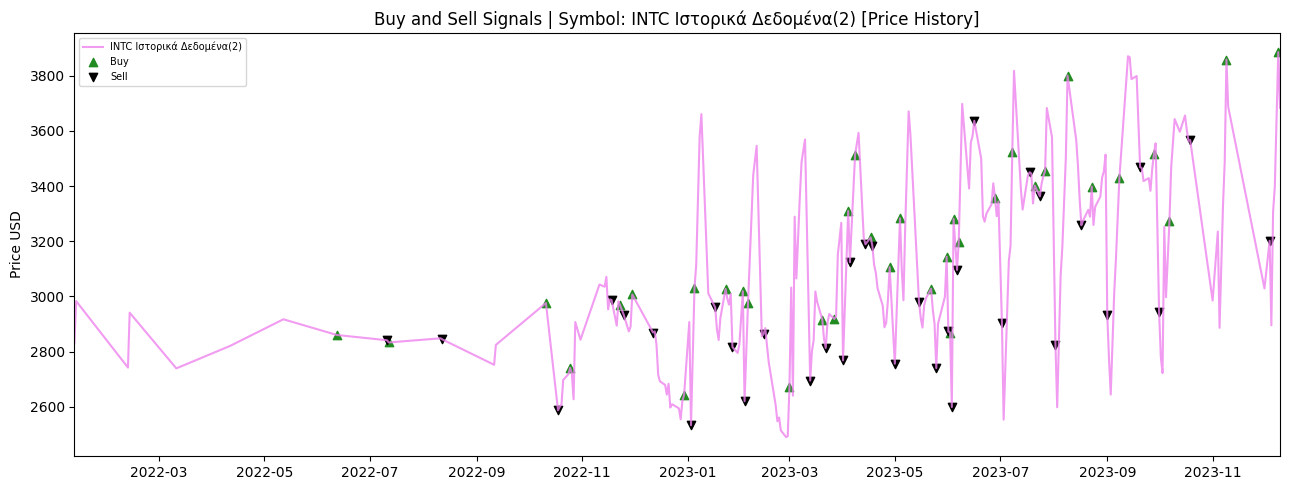

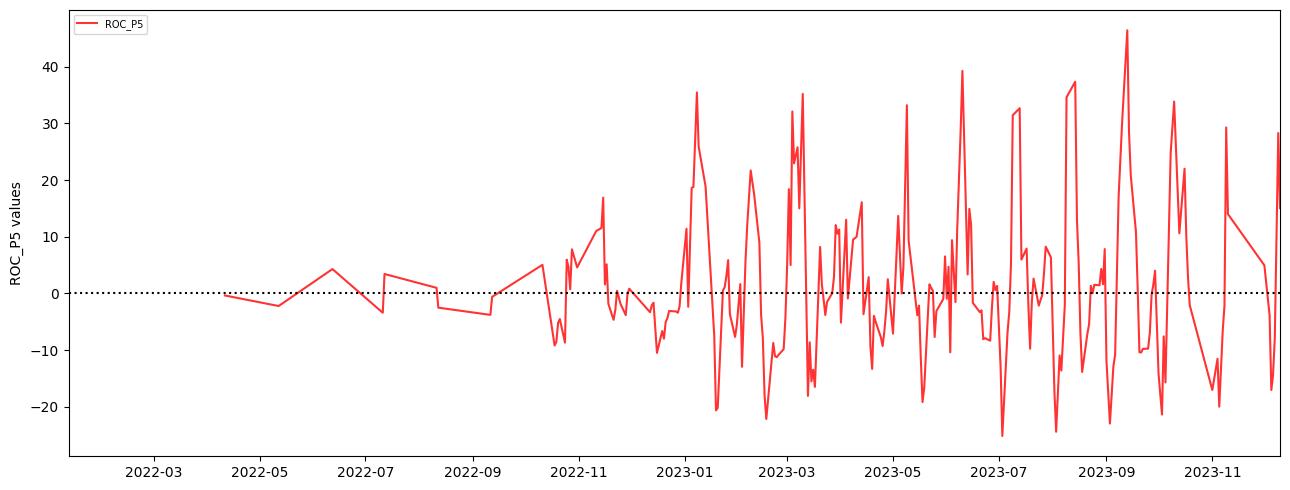

In [16]:
#Βήμα 7 | ROC Plot Analysis (Buy and Sell Signals)
roc_plot_total_signals(roc_results,roc_total_dates_report)